<a href="https://colab.research.google.com/github/utkarsh512/ABSA-Bert/blob/main/notebooks/3_%5BDEPRECATED%5D_TensorFlow_Bert_Classifying_Context_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Notes__: This notebook is deprecated.

# Predicting nature of future comment as ad-hominem and delta by training on preceding comments using BERT
Before running this notebook, make sure you have already finished running `1-prepare-dataset.ipynb` 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 5.7MB/s 
     |████████████████████████████████| 1.1MB 5.9MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 174kB 57.0MB/s 
     |████████████████████████████████| 1.2MB 55.9MB/s 
     |████████████████████████████████| 706kB 42.6MB/s 
     |████████████████████████████████| 358kB 53.4MB/s 
     |████████████████████████████████| 645kB 48.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

In [ ]:
import os

if tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recomended.')

Using GPU


In [ ]:
!nvidia-smi

Mon Mar 15 02:54:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/DL/fallacy/data/context'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2582 files belonging to 2 classes.
Using 2066 files for training.
Found 2582 files belonging to 2 classes.
Using 516 files for validation.


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
history = None

with strategy.scope():
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    epochs = 3
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')
    classifier_model = build_classifier_model()
    classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/3
65/65 [==============================] - 59s 631ms/step - loss: 0.7128 - binary_accuracy: 0.5290 - val_loss: 0.5773 - val_binary_accuracy: 0.7016
Epoch 2/3
65/65 [==============================] - 39s 601ms/step - loss: 0.5577 - binary_accuracy: 0.7188 - val_loss: 0.5755 - val_binary_accuracy: 0.7171
Epoch 3/3
65/65 [==============================] - 39s 602ms/step - loss: 0.4065 - binary_accuracy: 0.8238 - val_loss: 0.5988 - val_binary_accuracy: 0.7248


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


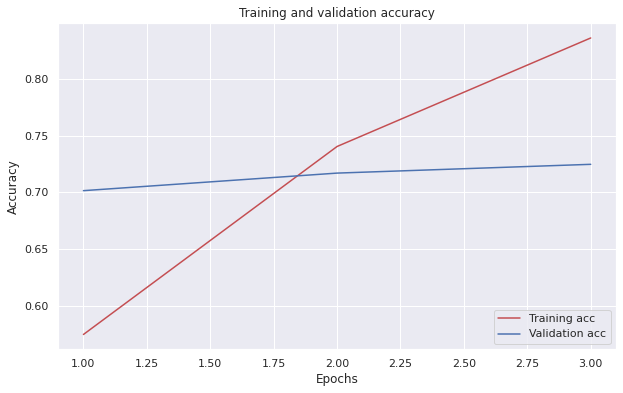

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 10)})

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
from tqdm import tqdm

test_ds = list(val_ds.as_numpy_iterator())

count = dict()
count['ah-ah'] = 0
count['ah-none'] = 0
count['none-none'] = 0
count['none-ah'] = 0

for i in tqdm(range(len(test_ds)), unit=" batches", desc="Batch processed"):
  comments = list(test_ds[i][0])
  gold_labels = list(test_ds[i][1])
  for j in range(len(comments)):
    comment = list()
    comment.append(comments[j])
    gold_label = gold_labels[j]
    result = tf.sigmoid(classifier_model(tf.constant(comment)))[0]
    true_label = 'ah'
    if gold_label == 1:
      true_label = 'none'
    pred_label = 'ah'
    if result > 0.5:
      pred_label = 'none'
    hsh = true_label + '-' + pred_label
    count[hsh] += 1

Batch processed: 100%|██████████| 17/17 [00:07<00:00,  2.21 batches/s]


In [ ]:
print(count)

{'ah-ah': 168, 'ah-none': 84, 'none-none': 206, 'none-ah': 58}
